In [1]:
import sys
import os
import toml

import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format

import numpy as np
import scipy.optimize as SciOpt
from scipy.special import rel_entr
from tqdm.notebook import tqdm
from copy import deepcopy

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
plt.rcParams.update(
    {
        # "text.usetex": True,
        "text.latex.preamble": r"\usepackage{bm}",
        # Enforce default LaTeX font.
        "font.family": "serif",
        "mathtext.fontset": "dejavuserif",
    }
)

In [4]:
sys.path.append(os.path.join(sys.path[0], '../..'))

from data.io import Reader
from data.data_generators import DataGenerator
from lsm.lsmtype import Policy
import lsm.cost as CostFunc
import lsm.solver as Solvers

In [5]:
config = Reader.read_config('../../endure.toml')
data_gen = DataGenerator(config)
wls = config['workloads']

VIZ_DIR = '/Users/ndhuynh/sandbox/viz'
ROBUST_DF = pd.read_csv('/Users/ndhuynh/sandbox/data/workload_uncertainty_tunings.csv')

In [6]:
def set_style(fsz=14):
    mpl.rcParams["font.size"] = f'{fsz}'
    plt.rc('axes', titlesize=fsz)
    plt.rc('axes', labelsize=fsz)
    plt.rc('xtick', labelsize=fsz)
    plt.rc('ytick', labelsize=fsz)
    plt.rc('legend', fontsize=fsz)
    plt.rc('figure', titlesize=fsz)
    
def set_size(fig, width=3.33, height=2, scale=1):
    fig.set_size_inches(width * scale, height * scale)
    plt.tight_layout()
    
def save_fig(fig, filename):
    fig.savefig(os.path.join(VIZ_DIR, filename), dpi=300, format='pdf', bbox_inches='tight')

In [7]:
def sample_workloads(samples=10000):
    wls = []
    np.random.seed(0)
    for _ in range(samples):
        wls.append(data_gen._sample_workload(4))
    return wls

def kl_div(w0: np.array, w1: np.array):
    return np.sum(rel_entr(w0, w1))

In [8]:
def get_tunings(cfg, workload, models):
    tunings = {model: get_tuning(cfg, workload, model=model) for model in models}
    return tunings

def get_tuning(cfg, workload, model='K', rho=2):
    solvers = {
        'Robust': Solvers.EndureLevelSolver,  # Special case below
        'Dostoevsky': Solvers.EndureDostoevskyFixedSolver,
        'Lazy Level': Solvers.EndureLazyLevelingSolver,
        'Y1': Solvers.EndureYSolver,
        'FluidLSM': Solvers.EndureYZSolver,
        'Q': Solvers.EndureQSolver,
        'K-LSM': Solvers.EndureKSolver,
        'Tier': Solvers.EndureTierSolver,
        'Nominal': Solvers.EndureLevelSolver,  # Special case below
        'Level': Solvers.EndureLevelSolver}
    z0, z1, q, w = np.array([workload[key] for key in ('z0', 'z1', 'q', 'w')])
    solver = solvers.get(model, None)
    if solver is None:
        print('Invalid model, returning Leveling')
        return solvers.get('Level')(cfg)
    solver = solver(cfg)
    if model == 'Robust':
        level_solver = solvers.get('Level')(cfg)
        level_design = level_solver.find_robust_design(rho, z0, z1, q, w)
        tier_solver = solvers.get('Tier')(cfg)
        tier_design = tier_solver.find_robust_design(rho, z0, z1, q, w)
        solver = tier_solver
        design = tier_design
        if level_design.fun < tier_design.fun:
            solver = level_solver
            design = level_design
        design = design.x[:-2]  # Remove lagrangian variables lambda eta
    elif model == 'Nominal':
        level_solver = solvers.get('Level')(cfg)
        level_design = level_solver.find_nominal_design(z0, z1, q, w)
        tier_solver = solvers.get('Tier')(cfg)
        tier_design = tier_solver.find_nominal_design(z0, z1, q, w)
        solver = tier_solver
        design = tier_design.x
        if level_design.fun < tier_design.fun:
            solver = level_solver
            design = level_design.x
    else:
        design = solver.find_nominal_design(z0, z1, q, w)
        design = design.x
    tuning = {'design': design, 'solver': solver}
    return tuning

In [9]:
def eval_nominal_objective(model, desc, z0, z1, q, w):
    x, s = desc['design'], desc['solver']
    if model == 'Dostoevsky':
        x = np.around(x)
    else:
        x = np.concatenate([[x[0]], np.around(x[1:])])
    return s.nominal_objective(x, z0, z1, q, w)

In [10]:
page_size = 4 * 1024 * 8  # 4 KiB in bits
total_size = 2**43  # 1 TiB in bits
entry_sizes = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]

In [58]:
def create_fixed_total_size_df(workload, models):
    tunings = {}
    for entry_size in (entry_sizes):
        total_entries = total_size / entry_size
        entry_per_page = page_size / entry_size
        cfg = deepcopy(config)
        cfg['system']['N'] = total_entries
        cfg['system']['B'] = entry_per_page
        cfg['system']['E'] = entry_size
        cfg['system']['M'] = max(2*33 * 10, cfg['system']['N'] * 10)
        tunings[entry_size] = get_tunings(cfg, workload, models)
    
    df = []
    samples = sample_workloads()
    # samples = [(workload[key] for key in ('z0', 'z1', 'q', 'w'))]
    for sample in tqdm(samples):
        z0, z1, q, w = sample
        row = {'z0': z0,
               'z1': z1,
               'q': q,
               'w': w,}
        for entry_size in entry_sizes:
            row['entry_size'] = entry_size
            for model in models:
                desc = tunings[entry_size][model]
                row[model] = eval_nominal_objective(model, desc, z0, z1, q, w)
            df.append(deepcopy(row))

    df = pd.DataFrame(df)
    return df, tunings

In [59]:
def create_fixed_total_entries_df(workload, models):
    tunings = {}
    for entry_size in (entry_sizes):
        entry_per_page = page_size / entry_size
        cfg = deepcopy(config)
        cfg['system']['N'] = 2**33
        cfg['system']['B'] = entry_per_page
        cfg['system']['E'] = entry_size
        tunings[entry_size] = get_tunings(cfg, workload, models)
    
    df = []
    samples = sample_workloads()
    # samples = [(workload[key] for key in ('z0', 'z1', 'q', 'w'))]
    for sample in tqdm(samples):
        z0, z1, q, w = sample
        row = {'z0': z0,
               'z1': z1,
               'q': q,
               'w': w,}
        for entry_size in entry_sizes:
            row['entry_size'] = entry_size
            for model in models:
                desc = tunings[entry_size][model]
                row[model] = eval_nominal_objective(model, desc, z0, z1, q, w)
            df.append(deepcopy(row))

    df = pd.DataFrame(df)
    return df, tunings

In [60]:
def plot_entry_size_graph(df, workload, models, plot_error=False):
    means = df.groupby('entry_size').mean()
    std = df.groupby('entry_size').mean()
    
    fig, ax = plt.subplots()
    for model in models:
        ax.plot(means.index.values / 8,  # entry sizes
                means[model],
                label=f'{model}',
                marker=markers[model],
                color=colors[model], 
                linestyle='dashed' if model == 'Robust' else 'solid')
        if plot_error:
            ax.fill_between(means.index.values / 8, means[model] - std[model], means[model] + std[model], alpha=0.2, color=colors.get(model, 'black'))
    ax.set_xscale('log', base=2)
    ax.set_yscale('log')
    positions = labels = means.index.values / 8
    ax.xaxis.set_major_locator(mpl.ticker.FixedLocator(positions))
    ax.xaxis.set_major_formatter(mpl.ticker.FixedFormatter(labels))
    ax.set_xticklabels([f'{x:,.0f}' for x in ax.get_xticks()])
    ax.set_xlabel('Entry Size (bytes)')
    ax.set_ylabel('Avg. I/O per Query')
    ax.legend(borderpad=0.3,
              labelspacing=0.2,
              ncol=2,
              loc='upper left',
              columnspacing=0.5,
              frameon=True).set_zorder(2)
    
    wl_id = workload['id']
    w0 = np.array([workload[key] for key in ('z0', 'z1', 'q', 'w')])
    title = f'$w_{{{wl_id}}}$: ({w0[0]:.0%}, {w0[1]:.0%}, {w0[2]:.0%}, {w0[3]:.0%})'
    if wl_id == 11:
        title += ' | Read-Heavy'
    else:
        title += ' | Mixed Read-Write'
    ax.set_title(title)
    
    return fig, ax

In [63]:
workload = wls[11]
# models = ['Robust', 'Nominal', 'Dostoevsky', 'Lazy Level', 'FluidLSM', 'K-LSM']
models = ['Robust', 'Nominal']
markers = ['*', 'o', '+', 'd', 'x', '1']
markers = {model: marker for model, marker in zip(models, markers)}
colors = ['tab:green', 'tab:gray', 'tab:orange', 'tab:blue', 'tab:purple', 'tab:cyan']
colors = {model: color for model, color in zip(models, colors)}

  0%|          | 0/10000 [00:00<?, ?it/s]

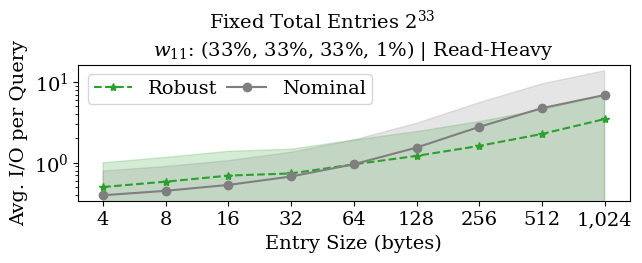

In [66]:
set_style(fsz=14)
df, tunings = create_fixed_total_entries_df(workload, models)
fig, ax = plot_entry_size_graph(df, workload, models, plot_error=True)
fig.suptitle('Fixed Total Entries $2^{33}$', y=0.88)
set_size(fig, width=2*3.33, height=1.5*2)
save_fig(fig, 'fixed_entries.pdf')

  0%|          | 0/10000 [00:00<?, ?it/s]

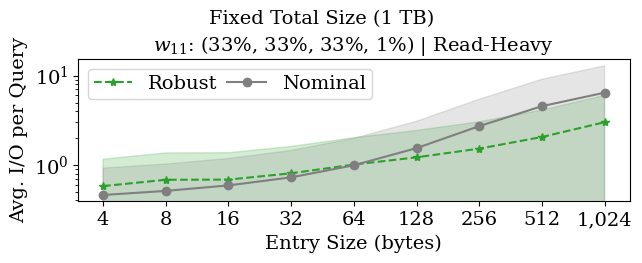

In [67]:
set_style(fsz=14)
df, tunings = create_fixed_total_size_df(workload, models)
fig, ax = plot_entry_size_graph(df, workload, models, plot_error=True)
fig.suptitle('Fixed Total Size (1 TB)', y=0.88)
set_size(fig, width=2*3.33, height=1.5*2)
save_fig(fig, 'fixed_size.pdf')

In [18]:
for entry_size in (entry_sizes):
    total_entries = total_size / entry_size
    entry_per_page = page_size / entry_size
    cfg['system']['N'] = total_entries
    cfg['system']['B'] = entry_per_page
    cfg['system']['E'] = entry_size
    print(cfg['system'])

{'B': 1024.0, 'phi': 1, 's': 1e-09, 'E': 32, 'H': 10, 'M': -1, 'N': 274877906944.0}
{'B': 512.0, 'phi': 1, 's': 1e-09, 'E': 64, 'H': 10, 'M': -1, 'N': 137438953472.0}
{'B': 256.0, 'phi': 1, 's': 1e-09, 'E': 128, 'H': 10, 'M': -1, 'N': 68719476736.0}
{'B': 128.0, 'phi': 1, 's': 1e-09, 'E': 256, 'H': 10, 'M': -1, 'N': 34359738368.0}
{'B': 64.0, 'phi': 1, 's': 1e-09, 'E': 512, 'H': 10, 'M': -1, 'N': 17179869184.0}
{'B': 32.0, 'phi': 1, 's': 1e-09, 'E': 1024, 'H': 10, 'M': -1, 'N': 8589934592.0}
{'B': 16.0, 'phi': 1, 's': 1e-09, 'E': 2048, 'H': 10, 'M': -1, 'N': 4294967296.0}
{'B': 8.0, 'phi': 1, 's': 1e-09, 'E': 4096, 'H': 10, 'M': -1, 'N': 2147483648.0}
{'B': 4.0, 'phi': 1, 's': 1e-09, 'E': 8192, 'H': 10, 'M': -1, 'N': 1073741824.0}


In [19]:
(2**33) / 8  / 1024 / 1024 / 1024

1.0